In [1]:
import pandas as pd
#from pandas_profiling import ProfileReport

from scikitplot.estimators import plot_learning_curve
from sklearn.ensemble import RandomForestRegressor

import numpy as np

import warnings
warnings.filterwarnings('ignore')

import gc
import tables

from sklearn.model_selection import train_test_split, cross_val_score, KFold

import xgboost as xgb
import eli5

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

In [2]:
print("#### import data")
train = pd.read_hdf('../input/train_data.h5')
test = pd.read_hdf('../input/test_data.h5') 
df_all = pd.concat([train, test], axis=0)
print("train & test: ", train.shape, test.shape)

#### import data
train & test:  (22732, 8) (11448, 7)


In [3]:
df_all

,geo_block,breadcrumbs,price,owner,params,date,user_block,id
0,"[г. Москва, Лианозово, г. Москва, Лианозово]","[Москва, Лианозово, м. Алтуфьево, МЦК Лихоборы]",5 402 084 ₽,[],"{'Охрана:': 'закрытая территория', 'Тип здания...","[22 апреля, 12, (+1 за сегодня), Обновлено 18 ...","[<div class=""block-user__name"">НДВ Недвижимост...",34995
1,"[г. Москва, Ховрино, г. Москва, Ховрино]","[Москва, Ховрино, м. Ховрино, МЦК Коптево]",6 827 990 ₽,[],"{'Лифт:': 'да', 'Тип здания:': 'Монолитное', '...","[10 мая, 2, (+1 за сегодня), Обновлено 16 мая]","[<div class=""block-user__name"">MR-Group</div>,...",15030
2,"[г. Москва, ул Лобачевского, г. Москва, ул Лоб...","[Москва, МЦК Кутузовская, ул. Лобачевского]",8 680 000 ₽,"[ЖК ""Крылья"". Доп. скидка 5%!]","{'Лифт:': 'да', 'Охрана:': 'закрытая территори...","[20 марта, 12, (+2 за сегодня), Обновлено 18 мая]",[],37811
3,"[г. Москва, Ховрино, ул Дыбенко, г. Москва, Хо...","[Москва, Ховрино, м. Ховрино, МЦК Коптево, ул....",8 624 435 ₽,[],"{'Лифт:': 'да', 'Тип здания:': 'Монолитное', '...","[29 апреля, 3, (+1 за сегодня), Обновлено 13 мая]","[<div class=""block-user__name"">MR-Group</div>,...",31685
4,"[г. Москва, Даниловский, г. Москва, Даниловский]","[Москва, Даниловский, м. Автозаводская, МЦК Ав...",29 500 000 ₽,[],"{'Общая площадь:': '141.1 м²', 'Дата публикаци...","[15 декабря 2018, 30, (+1 за сегодня), Обновле...","[<div class=""block-user__name"">Наталья Вдовиче...",56215
...,...,...,...,...,...,...,...,...
11443,"[г. Москва, г. Москва]","[Москва, МЦК Кутузовская]",NaN,[],"{'Лифт:': 'да', 'Охрана:': 'предусмотрена', 'Т...","[17 мая, 3, (+2 за сегодня)]","[<div class=""block-user__name"">MR Group</div>,...",47294
11444,"[г. Москва, Хорошёво-Мнёвники, г. Москва, Хоро...","[Москва, Хорошёво-Мнёвники, м. Октябрьское пол...",NaN,[],"{'Лифт:': 'да', 'Охрана:': 'предусмотрена', 'Т...","[16 мая, 1, (+1 за сегодня)]","[<div class=""block-user__name"">Офис продаж ЖК ...",14091
11445,"[г. Москва, Ховрино, г. Москва, Ховрино]","[Москва, Ховрино, м. Ховрино, МЦК Коптево]",NaN,[],"{'Лифт:': 'да', 'Тип здания:': 'Монолитное', '...","[10 мая, 1, (+1 за сегодня), Обновлено 16 мая]","[<div class=""block-user__name"">MR-Group</div>,...",13059
11446,"[Новая Москва, п. Внуковское, г. Москва, Новая...","[Москва, Новая Москва, п. Внуковское, МЦК Куту...",NaN,[Переделкино Ближнее],"{'Лифт:': 'да', 'Охрана:': 'консьерж', 'Тип зд...","[вчера в 10:14, 2, (+2 за сегодня)]",[],10144


# FEATURE ENGINEER

## ==> FUNCTIONS

In [4]:
def parse_price(val):
    if isinstance(val, str): 
        if "₽" in val:
            val = val.split('₽')[0]
            
        val = val.replace(' ', '')
        return int(val) / 1000000
    
    return float(val)

def extract_geoblock(vals):
    vals = vals[: int(len(vals) / 2)]
    return {"geo_block_{}".format(idx):val.strip().lower() for idx, val in enumerate(vals)}

def extract_breadcrumbs(vals):
    vals = vals[: int(len(vals) / 2)]
    return {"breadcrumbs{}".format(idx):val.strip().lower() for idx, val in enumerate(vals)}

#SPLIT DATA
def split_breadcrumbs(row, string):
    result = "-1"
    len_ = len(row)
    for x in range(len_):
        if string in row[x]:
            result = row[x]

    return result


def split_date(row, idx):
    result = "-1"
    len_ = len(row)
    if len_ > idx:
        result = row[idx]

    return result

def split_date_DMY(row, idx):
    result = "-1"
    
    date_ = row.split(' ')
    len_ = len(date_)
    if len_ > idx:
        result = date_[idx]
        if "сегодня" in result:
            result = "+2"
        if "вчера" in result:
            result = "+1"
        if ":" in result:
            result = "-1"
            
    return result

def parse_area(val):
    if isinstance(val, int): return val
    if isinstance(val, float): return val
    
    return float(val.split("м")[0].replace(" ", ""))

def check_model(df, feats, model, cv=5, scoring="neg_mean_absolute_error"):
    df_train = df[ ~df["price"].isnull() ].copy()
    df_test = df[ df["price"].isnull() ].copy()

    X_train = df_train[feats]
    y_train = df_train["price"]

    X_test = df_test[feats]
    
    
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
    
    plot_learning_curve(model, X_train, y_train, cv=cv, random_state=0, shuffle=True)
    plt.show()
    
    return np.mean(scores), np.std(scores)

In [5]:
#month
month = pd.DataFrame({ "date_0_1" : ["января","февраля","марта","апреля","мая",
                                     "июня","июля","августа","сентября",
                                     "октября","ноября","декабря" ],
                       "date_month_cat" : ['01','02','03','04','05','06','07',
                                          '08','09','10','11','12']
                    })

# STACJE METRA, WSPÓŁRZĘDNE, ODLEGŁOŚCI OD:
# PLACU CZERWONEGO
# LOTNISK
metro_stations = pd.DataFrame({
"breadcrumbs_MCK":[
         "МЦК Крымская","МЦК Кутузовская","МЦК Шелепиха","МЦК Лужники","МЦК Коптево","МЦК Хорошёво",
         "МЦК ЗИЛ","МЦК Шоссе Энтузиастов","МЦК Нижегородская","МЦК Угрешская","МЦК Владыкино",
         "МЦК Лихоборы","МЦК Ботанический сад","МЦК Балтийская","МЦК Зорге","МЦК Ростокино",
         "МЦК Локомотив","МЦК Деловой центр","МЦК Андроновка","МЦК Новохохловская","МЦК Соколиная Гора",
         "МЦК Стрешнево","МЦК Площадь Гагарина","МЦК Окружная","МЦК Панфиловская","МЦК Верхние Котлы",
         "МЦК Дубровка","МЦК Бульвар Рокоссовского","МЦК Автозаводская","МЦК Белокаменная","МЦК Измайлово"
        ],
 "N_cat"    :[
     55.689996,55.739723,55.759055,55.720938,55.8339615,55.777063,
     55.697998,55.758903,55.732153,55.7172056,55.8460453,
     55.8461625,55.8456095,55.8245848,55.7889196,55.84286,
     55.8032813,55.7477698,55.7459043,55.7240081,55.7715129,
     55.813731,55.706997,55.8488708,55.7990171,55.690124,
     55.7126485,55.817222,55.706525,55.8247339,55.7884887
 ],
 "E_cat"    :[
     37.6030233,37.5322383,37.5204276,37.5578673,37.5095698,37.5052353,
     37.6455663,37.7438224,37.7259292,37.694126,37.5871309,
     37.57181,37.6375244,37.4928893,37.5017478,37.6630943,
     37.7431398,37.5298063,37.7356328,37.7143756,37.7429271,
     37.4848013,37.5841133,37.5699377,37.4967285,37.6165353,
     37.675508,37.7347544,37.6612083,37.6935242,37.7423137     
 ],
 "dist_to_red_square_cat" :[
     0.065474699499651200,0.087583479903288500,0.098447525258996600,0.069047169411717700,0.135566934589415000,0.115894398869703000,
     0.061707928222957200,0.125214708292993000,0.109324042363335000,0.083710909065539700,0.097730971999673100,
     0.103806377065432000,0.093949381526707200,0.144492862318421000,0.122201190447971000,0.099715880839365500,
     0.133985005816959000,0.089103788900196600,0.117161550121057000,0.100115116606079000,0.125496038555646000,
     0.146816601480113000,0.058016705643890100,0.107069396626726000,0.130186815633074000,0.063474566769454200,
     0.069989344485068300,0.132349246777230000,0.063383649850489500,0.103252166733923000,0.128432603636457000
 ],
 "dist_to_airport_Szere_cat":[
     0.296360388194812000,0.230551909339703000,0.224014637566945000,0.252853413120291000,0.247605377828677000,0.216000276998391000,
     0.338948568412645000,0.442235366506402000,0.421173209378202000,0.388272034151328000,0.319959674379398000,
     0.306677693421351000,0.364755362770447000,0.228569990859038000,0.217807025951987000,0.387018390667653000,
     0.450421186246167000,0.229989094738207000,0.432330698167272000,0.408956539604296000,0.443435782471661000,
     0.215726846441931000,0.277845867499556000,0.306437585575431000,0.218094277412802000,0.309871258872106000,
     0.369412974341512000,0.446010492707349000,0.354833843221558000,0.408977175985263000,0.446191310536960000

 ],
 "dist_to_airport_Domod_cat":[
     0.280352599357255000,0.341505576431436000,0.363322450119583000,0.317243187838553000,0.438396276839995000,0.384985918522181000,
     0.288630376759217000,0.369170636618699000,0.338118239531228000,0.315191688822688000,0.437155363452810000,
     0.438770252015069000,0.435568753432807000,0.434019909475090000,0.397341648226938000,0.434472516266529000,
     0.411133993349334000,0.349908952325272000,0.354217392443069000,0.326934821351179000,0.380815829261124000,
     0.426212235233535000,0.299137479860966000,0.441678723023929000,0.408489652356089000,0.279876472868956000,
     0.306987858059841000,0.422168110091536000,0.298762491551681000,0.420502840941041000,0.396767924663372000

 ],
 "dist_to_airport_Wnuko_cat":[
     0.296363998094992000,0.230497277313749000,0.223934803143412000,0.252824010555265000,0.247450606297197000,0.215894638429606000,
     0.338945492302891000,0.442195833660878000,0.421148940052902000,0.388256068177328000,0.319830009818745000,
     0.306542226606790000,0.364642174455572000,0.228413390746622000,0.217687396939553000,0.386913757493900000,
     0.450355517985038000,0.229924775435290000,0.432298423060469000,0.408936927525318000,0.443388603635436000,
     0.215574576576760000,0.277832934882547000,0.306299593354689000,0.217962145505179000,0.309874668582722000,
     0.369399474317778000,0.445935626128301000,0.354824426806060000,0.408890361344124000,0.446134052143902000
 
        
 ]
})

In [6]:
print("############ start extract") 
print("#### extract price")  
df_all['price'] = df_all['price'].map(parse_price)

print("#### extract params")  
params = df_all["params"].apply(pd.Series)
params = params.fillna(-1)

if "Охрана:" not in df_all:
    df_all = pd.concat([df_all, params], axis=1)
    
obj_feats = params.select_dtypes(object).columns

for feat in obj_feats:
    df_all["{}_cat".format(feat)] = df_all[feat].factorize()[0]    


print("#### extract geo_block")      
df_geo_block = df_all["geo_block"].map(extract_geoblock).apply(pd.Series)
df_all = pd.concat([df_all, df_geo_block], axis=1)

feats_geo_block = [ x for x in df_geo_block.columns]

for f in feats_geo_block:
    df_all["{}_cat".format(f)] = df_all[f].factorize()[0]    
    
print("#### extract breadcrumbs 1")      
df_breadcrumbs = df_all["breadcrumbs"].map(extract_breadcrumbs).apply(pd.Series)
df_all = pd.concat([df_all, df_breadcrumbs], axis=1)

feats_breadcrumbs = [ x for x in df_breadcrumbs.columns]
for f in feats_breadcrumbs:
    df_all["{}_cat".format(f)] = df_all[f].factorize()[0]
    
#breadcrumbs = (
#    df_all["breadcrumbs"]
#        .map(lambda x: {"breadcrumbs_{}".format(idx):val for idx,val in enumerate(x) })
#        .apply(pd.Series)
#)
#
#for feat in breadcrumbs.columns:
#    df_all["{}_cat".format(feat)] = breadcrumbs[feat].factorize()[0]    
    
    
print("#### extract breadcrumbs 2")
df_all["breadcrumbs_MCK"] = df_all.apply(lambda df: split_breadcrumbs(df["breadcrumbs"],"МЦК "), axis=1)
#df_all["breadcrumbs_STR"] = df_all.apply(lambda df: split_breadcrumbs(df["breadcrumbs"],"ул. "), axis=1)
df_all = df_all.merge(metro_stations, how="left", on=["breadcrumbs_MCK"])    

df_all["N_cat"] = df_all["N_cat"].fillna(-1)
df_all["E_cat"] = df_all["E_cat"].fillna(-1)
df_all["dist_to_red_square_cat"] = df_all["dist_to_red_square_cat"].fillna(-1)
df_all["dist_to_airport_Szere_cat"] = df_all["dist_to_airport_Szere_cat"].fillna(-1)
df_all["dist_to_airport_Domod_cat"] = df_all["dist_to_airport_Domod_cat"].fillna(-1)
df_all["dist_to_airport_Wnuko_cat"] = df_all["dist_to_airport_Wnuko_cat"].fillna(-1)

df_all['breadcrumbs_MCK_cat'] = pd.factorize(df_all['breadcrumbs_MCK'])[0]

df_all["breadcrumbs_count_cat"] = df_all["breadcrumbs"].apply(lambda x: len(str(x).split(",")))

print("#### extract date")
df_all["date_0"] = df_all.apply(lambda df: split_date(df["date"],0), axis=1)
df_all["date_1"] = df_all.apply(lambda df: split_date(df["date"],1), axis=1)
df_all["date_2"] = df_all.apply(lambda df: split_date(df["date"],2), axis=1)

df_all["date_day_no"] = df_all.apply(lambda df: split_date_DMY(df["date_0"],0), axis=1)
df_all["date_0_1"] = df_all.apply(lambda df: split_date_DMY(df["date_0"],1), axis=1)
df_all["date_year_cat"] = df_all.apply(lambda df: split_date_DMY(df["date_0"],2), axis=1)

df_all = df_all.merge(month, how="left", on=["date_0_1"])

df_all["date_month_cat"] = df_all["date_month_cat"].fillna(-10)
df_all["date_1_cat"] = pd.factorize(df_all['date_1'])[0]

df_all = df_all.astype({
                        "date_month_cat": int, 
                        "date_year_cat": int}
                       )

max_year = df_all["date_year_cat"].max()

#find data in last year
df_in_last_year = df_all["date_year_cat"] == -1
df_all.loc[df_in_last_year,"date_year_cat"] = max_year + 1


max_month = df_all["date_month_cat"].where(df_in_last_year).max()
df_in_last_month = df_all["date_month_cat"] == -10
df_all.loc[df_in_last_month,"date_month_cat"] = max_month

max_new_year = df_all["date_year_cat"].max()
df_in_new_year = df_all["date_year_cat"] == max_new_year
max_new_month = df_all["date_month_cat"][df_in_new_year].max()#.astype(int)
df_in_new_year_month = df_all["date_month_cat"] == max_new_month
max_new_day = int(df_all["date_day_no"][df_in_new_year & df_in_new_year_month].max())

df_all["date_day_"] = df_all["date_day_no"].apply(lambda x : int(x) + max_new_day  if "+" in x else x)

df_all = df_all.astype({
                        "date_month_cat": int, 
                        "date_year_cat": int, 
                        "date_day_": int}
                       )

df_all["year"] = df_all["date_year_cat"]
df_all["month"] = df_all["date_month_cat"]
df_all["day"] = df_all["date_day_"]
df_all["date_date"] = pd.to_datetime(df_all[["year","month","day"]])
df_all["date_week_cat"] = df_all["date_date"].dt.week
df_all["date_dayodweek_cat"] = df_all["date_date"].dt.dayofweek

print("#### extract owner")
df_all["owner_cat"] = df_all["owner"].apply(lambda x: 1 if len(str(x)) > 2 else 0)


print("#### extract area")
df_all["Общая площадь:"].map(lambda x: float(x.split("м")[0].replace(" ", "")) )

df_all["area"] = df_all["Общая площадь:"].map(parse_area)

print("############ end extract")     

############ start extract
#### extract price
#### extract params
#### extract geo_block
#### extract breadcrumbs 1
#### extract breadcrumbs 2
#### extract date
#### extract owner
#### extract area
############ end extract


In [7]:
#breadcrumbs = (
#    df_all["breadcrumbs"]
#        .map(lambda x: {"breadcrumbs_{}".format(idx):val for idx,val in enumerate(x) })
#        .apply(pd.Series)
#)
#
#for feat in breadcrumbs.columns:
#    #print(feat)
#    #print(breadcrumbs[feat].value_counts().head(20))
#    #print("="*100)
#    #print()
#    
#
#    df_all["{}_cat".format(feat)] = breadcrumbs[feat].factorize()[0]

In [8]:
#df_all.info(verbose=True, null_counts=True)

In [7]:
print("#### extract area")
df_all["Общая площадь:"].map(lambda x: float(x.split("м")[0].replace(" ", "")) )
df_all["area"] = df_all["Общая площадь:"].map(parse_area)

print("#### extract kitchen_area")
df_all["kitchen_area"] = df_all["Площадь кухни:"].map(parse_area)

print("#### extract ceiling_height")
df_all["ceiling_height"] = df_all["Высота потолков:"].map(parse_area)

print("#### extract living_room")
df_all["living_room"] = df_all["Жилая комната:"].map(parse_area)

print("#### extract mumber_of_rooms")
df_all["mumber_of_rooms"] = df_all["Количество комнат:"].map(parse_area)


#### extract area
#### extract kitchen_area
#### extract ceiling_height
#### extract living_room
#### extract mumber_of_rooms


In [8]:
#df_all["Количество этажей:"]
df_all = df_all.astype({
                        "Количество корпусов:": int,
                        "Количество этажей:": int,
                        "Количество квартир:": int,
                        "Предоплата:": int}
                       )

In [10]:

feats = [x for x in df_all.columns if "_cat" in x]
feats.append("area")
feats.append("kitchen_area")
feats.append("ceiling_height")
feats.append("living_room")
feats.append("mumber_of_rooms")
feats.append("Количество этажей:")
feats.append("Количество корпусов:")
feats.append("Количество квартир:")
feats.append("Предоплата:")

#feats_tmp = df_all[ False ==  df_all["price"].isnull() ].select_dtypes(include= [np.int8,np.int16,np.int64]).columns.values
feats_tmp = df_all[ False ==  df_all["price"].isnull() ].select_dtypes(include= [np.int8,np.int16,np.int64]).columns.values
#df_all[[x for x in df_all.columns if "_cat" in x]] = df_all[[x for x in df_all.columns if "_cat" in x]].astype(np.int)
df_all[feats_tmp] = df_all[feats_tmp].astype(np.int)
print("feats: ", len(feats))
print(feats)


feats:  88
['Охрана:_cat', 'Тип здания:_cat', 'Тип объекта:_cat', 'Количество корпусов:_cat', 'Тип объявления:_cat', 'Застройщик:_cat', 'Общая площадь:_cat', 'Дата публикации:_cat', 'Количество комнат:_cat', 'Парковка:_cat', 'Дата  обновления:_cat', 'Количество этажей:_cat', 'Сдача:_cat', 'Комиссия агенту:_cat', 'Высота потолков:_cat', 'Этаж:_cat', 'Этап строительства:_cat', 'Новостройка:_cat', 'Количество квартир:_cat', 'Класс жилья:_cat', 'Адрес:_cat', 'Лифт:_cat', 'Вид из окна:_cat', 'Возможна ипотека:_cat', 'Год постройки:_cat', 'Этажность:_cat', 'Мусоропровод:_cat', 'Ремонт:_cat', 'Площадь кухни:_cat', 'Жилая комната:_cat', 'Тип санузла:_cat', 'Тип балкона:_cat', 'Мебель на кухне:_cat', 'Холодильник:_cat', 'Интернет:_cat', 'Мебель:_cat', 'Телефон:_cat', 'Свободная планировка:_cat', 'Управляющая компания:_cat', 'Количество подъездов:_cat', 'Тип дома:_cat', 'Тип комнат:_cat', 'Покрытие пола:_cat', 'Серия:_cat', 'Тип перекрытия:_cat', 'Возможен торг:_cat', 'Класс:_cat', 'Телевизор:_c

In [11]:
def check_log_model(df, feats, model, cv=5, scoring="neg_mean_absolute_error"):
    df_train = df[ ~df["price"].isnull() ].copy()

    X = df_train[feats]
    y = df_train["price"]
    y_log = np.log(y)
    
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y_log.iloc[train_idx], y.iloc[test_idx]

        #model = xgb.XGBRegressor(max_depth=5, n_estimators=50, random_state=0)
        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)

        score = mean_absolute_error(y_test, y_pred)
        scores.append(score)
        
    plot_learning_curve(model, X_train, y_log_train, cv=cv, random_state=0, shuffle=True)
    plt.show()

    return np.mean(scores), np.std(scores)

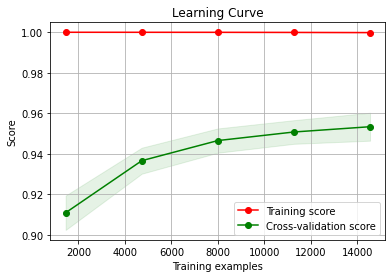

Wall time: 2min 56s


(2.560009502907912, 0.32581368949950384)

In [43]:
model_ =xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
%time check_log_model(df_all, feats, model_)

# ZAPISANIE PLIKU

In [44]:
df_train = df_all[ ~df_all["price"].isnull() ].copy()
df_test = df_all[ df_all["price"].isnull() ].copy()

X_train = df_train[feats]
y_train = df_train["price"]
y_log_train = np.log(y_train)

X_test = df_test[feats]

model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
model.fit(X_train, y_log_train)
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)


df_test["price"] = y_pred
df_test[ ["id", "price"] ].to_csv("_final_02_FindModel__score_.csv", index=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# GridSearchCV

In [39]:
def check_log_model_GS(df, feats, model, param_grid, cv=5, scoring="neg_mean_absolute_error"):
    df_train = df[ ~df["price"].isnull() ].copy()

    X = df_train[feats]
    y = df_train["price"]
    y_log = np.log(y)
    
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y_log.iloc[train_idx], y.iloc[test_idx]

        #model = xgb.XGBRegressor(max_depth=5, n_estimators=50, random_state=0)
        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)
        
        grid = GridSearchCV(model, param_grid = param_grid, cv = 5, verbose = 3, n_jobs = -1,)
        %time grid.fit(X_train, y_log_train)


    return grid

In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = {
#    'n_estimators': [50, 200, 400, 600],
#    'max_depth': [5, 10, 20, 30],
#    'learning_rate': [0.1, 0.05],
#    'random_state': [0, 20, 40],
#    'n_jobs': [-1]
    'n_estimators': [700, 800, 900, 1000],
    'max_depth': [8, 12],
    'learning_rate': [0.1],
    'random_state': [0],
    'n_jobs': [-1]    
}


In [41]:
%time best_estimator = check_log_model_GS(df_all, feats, xgb.XGBRegressor(), param_grid)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Wall time: 3min 13s
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Wall time: 3min 18s
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Wall time: 3min 28s
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Wall time: 3min 20s
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Wall time: 3min 15s
Wall time: 16min 40s


In [42]:
best_estimator.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)